In [ ]:
# Importing required libraries 
import PIL
from PIL import Image
import matplotlib.pyplot as plt
from keras.preprocessing import image
import numpy as np
%matplotlib inline
from pylab import *
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv2D, Conv2DTranspose, MaxPooling2D, Concatenate, UpSampling2D, Cropping2D
from tensorflow.keras import backend as K
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint, TensorBoard
from tensorflow.keras.preprocessing.image import load_img, img_to_array

In [ ]:
# Creating architecture of the model
class UNet:
    
    def __init__(self, img_dim=None):
        self.img_shape = (img_dim, img_dim, 3)
    
    def conv_block(self, x, filters, pool=True):
        conv = Conv2D(filters=filters, kernel_size=(3,3), padding='same', activation='relu', kernel_initializer='he_uniform')(x)
        res = Conv2D(filters=filters, kernel_size=(3,3), padding='same', activation='relu', kernel_initializer='he_uniform')(conv)
        if pool:
            out = MaxPooling2D()(res)
            return out, res
        else:
            return res
    
    def decoder_block(self, x, res, filters):
        x = UpSampling2D()(x)
        conv = Conv2D(filters=filters, kernel_size=(2,2), padding='same')(x)
        cropping_size = res.get_shape().as_list()[1] - conv.get_shape().as_list()[1]
        crop = Cropping2D(cropping=cropping_size//2)(res)
        merged = Concatenate()([conv, crop])
        conv_op_1 = Conv2D(filters=filters, kernel_size=(3,3), padding='same', activation='relu')(merged)
        out = Conv2D(filters=filters, kernel_size=(3,3), padding='same', activation='relu')(conv_op_1)    
        return out
    
    def create_model(self):
        img = Input(shape=self.img_shape)
        filters = [64, 128, 256, 512, 1024]
        x = img
        residuals = []
        pool = True
        """ Encoder """
        for fil in filters:
            if fil == 1024:
                pool = False
            if pool == True: 
                x, res = self.conv_block(x, fil, pool=pool)
                residuals.append(res)
            else:
                x = self.conv_block(x, fil, pool=pool)        
        counter = -1
        """ Decoder """        
        for fil in reversed(filters[:-1]):
            x = self.decoder_block(x, residuals[counter], fil)             
            counter = counter - 1            
        """ Output """
        out = Conv2D(filters=1, kernel_size=(1,1), padding='same', activation='sigmoid')(x)        
        model = Model(inputs=img, outputs=out)        
        return model

In [ ]:
# Data Augmentation for the images and masks
data_gen_general = dict(rescale=1./255,
                     rotation_range=90.,
                     width_shift_range=0.1,
                     height_shift_range=0.1,
                     zoom_range=0.2,
                     horizontal_flip=True,
                     vertical_flip=True,
                     shear_range=0.2,
                     brightness_range=(0.5, 1.0),
                     validation_split=0.2
                    )
image_datagen_general = ImageDataGenerator(**data_gen_general)
mask_datagen_general = ImageDataGenerator(**data_gen_general)

In [ ]:
# Connecting notebook to google drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
seed = 1
data_directory = '/content/drive/MyDrive/ImageSegmentation/banana/'

In [ ]:
#Loading data and augmenting data 
img_size = 256

image_arguments = dict(seed=seed,
    batch_size=32,
    shuffle=True,
    class_mode=None,
    target_size=(img_size, img_size),
    color_mode='rgb')

mask_arguments = dict(seed=seed,
    batch_size=32,
    class_mode=None,
    shuffle=True,
    target_size=(img_size, img_size), 
    color_mode='grayscale')

dir = '/content/drive/MyDrive/ImageSegmentation/banana/'
images = 'images'
masks = 'masks'

train_generator = zip(image_datagen_general.flow_from_directory(**image_arguments, directory=dir+'training_'+images),  
                      mask_datagen_general.flow_from_directory(**mask_arguments, directory=dir+'training_'+masks))

validation_generator = zip(image_datagen_general.flow_from_directory(**image_arguments, directory=dir+'validation_'+images),  
                      mask_datagen_general.flow_from_directory(**mask_arguments, directory=dir+'validation_'+masks))

Found 6 images belonging to 1 classes.


/usr/local/lib/python3.7/dist-packages/keras_preprocessing/image/utils.py:179: UserWarning: Using ".tiff" files with multiple bands will cause distortion. Please verify your output.
  warnings.warn('Using ".tiff" files with multiple bands '


Found 6 images belonging to 1 classes.
Found 2 images belonging to 1 classes.
Found 2 images belonging to 1 classes.


In [ ]:
img_train, mask_train = next(train_generator)

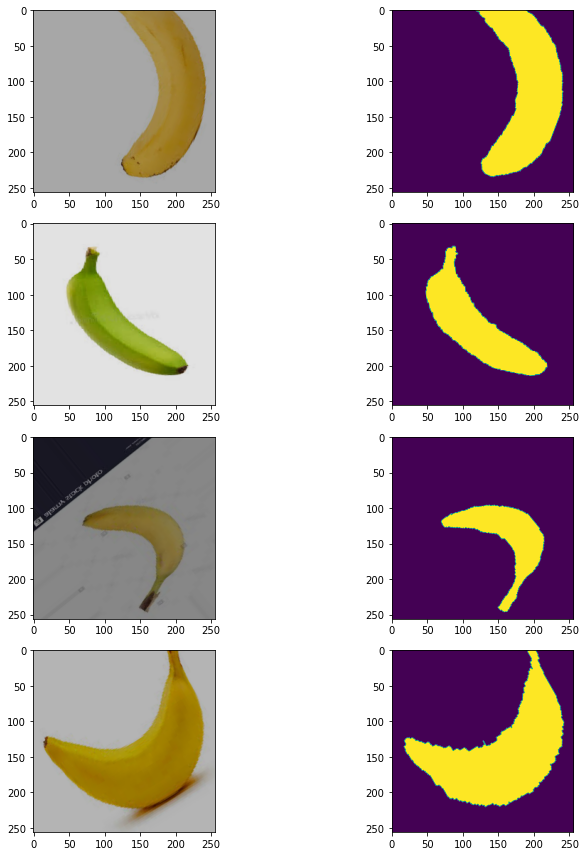

In [ ]:
# Augmented data set
fig=plt.figure(figsize=(12,12))
columns = 2
rows = 4
counter = 0
c = 0
for i in range(1, columns*rows +1):
    #img = np.random.randint(10, size=(h,w))
    fig.add_subplot(rows, columns, i)
    if counter%2 == 0:
        plt.imshow(img_train[c])
    else:
        plt.imshow(mask_train[c][:,:,0])
        c = c + 1
    counter = counter + 1
    

plt.tight_layout()
plt.savefig('augmented.png')
plt.show()

In [ ]:
# Creating model and compiling using the adam optimiser
net = UNet(img_dim=img_size)
model = net.create_model()

model.compile(optimizer=Adam(1e-4), loss='binary_crossentropy',
                  metrics=['accuracy'])

In [ ]:
#Defining Callbacks
filepath = 'best_weights.hdf5'

earlystopping = EarlyStopping(monitor='val_loss',
                           patience=8,
                           verbose=1,
                           min_delta=1e-4)

checkpoint    = ModelCheckpoint(monitor='val_loss',
                             filepath=filepath,
                             save_best_only=True,
                             save_weights_only=True)


callback_list = [earlystopping, checkpoint]

In [ ]:
# Training model 
unet_history = model.fit(train_generator, 
                         steps_per_epoch=135, 
                         epochs=10, 
                         validation_data=validation_generator,
                         validation_steps=16, 
                         callbacks=callback_list, 
                         workers=2)

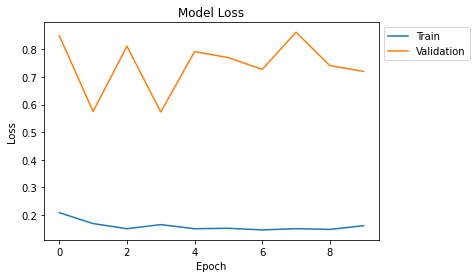

In [ ]:
plt.plot(unet_history.history['loss'])
plt.plot(unet_history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left', bbox_to_anchor=(1,1))
plt.show()

In [ ]:
# Saving model
model.save('/content/drive/MyDrive/VGG16/UNETSegmentation')

In [ ]:
#Loading mdoel
reconstructed_model = keras.models.load_model('/content/drive/MyDrive/VGG16/UNETSegmentation')

In [ ]:
img, mask = next(train_generator)

In [ ]:
test_mask = reconstructed_model.predict(img[0][np.newaxis, :])

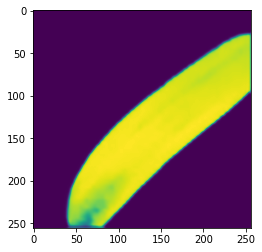

In [ ]:
plt.imshow(test_mask[0,:,:,0])

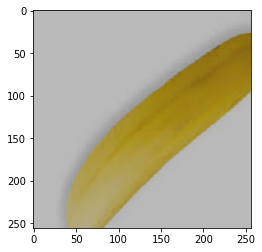

In [ ]:
plt.imshow(img[0])

In [ ]:
data_gen_test = dict(rescale=1./255)
image_datagen = ImageDataGenerator(**data_gen_test)
mask_datagen = ImageDataGenerator(**data_gen_test)

In [ ]:
#Loading test data 
image_args = dict(seed=seed,
    batch_size=17,
    shuffle=True,
    class_mode=None,
    target_size=(img_size, img_size),
    color_mode='rgb')

mask_args = dict(seed=seed,
    batch_size=17,
    class_mode=None,
    shuffle=True,
    target_size=(img_size, img_size), 
    color_mode='grayscale')
test_generator = zip(image_datagen.flow_from_directory(**image_args, directory='/content/drive/MyDrive/ImageSegmentation/banana/test_images/'),  
                      mask_datagen.flow_from_directory(**mask_args, directory='/content/drive/MyDrive/ImageSegmentation/banana/test_masks/'))

Found 2 images belonging to 1 classes.
Found 2 images belonging to 1 classes.


/usr/local/lib/python3.7/dist-packages/keras_preprocessing/image/utils.py:179: UserWarning: Using ".tiff" files with multiple bands will cause distortion. Please verify your output.
  warnings.warn('Using ".tiff" files with multiple bands '


In [ ]:
# Calculating accuracy and loss on test data
loss, accuracy = reconstructed_model.evaluate(test_generator, steps=15)
print("Test dataset Loss: %f and accuracy: %f" % (loss,accuracy))

15/15 [==============================] - 1s 57ms/step - loss: 0.3423 - accuracy: 0.8062
Test dataset Loss: 0.342273 and accuracy: 0.806160


In [ ]:
img, mask = next(test_generator)

In [ ]:
mask_test = reconstructed_model.predict(img[1][np.newaxis, :])

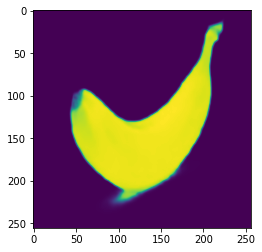

In [ ]:
plt.imshow(mask_test[0,:,:,0])

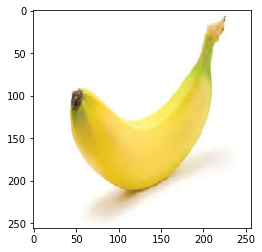

In [ ]:
plt.imshow(img[1])

Text(0.5, 1.0, 'Predicted Mask')

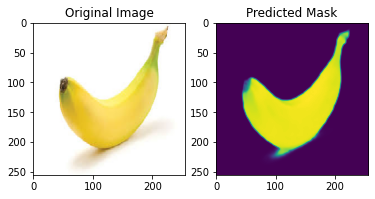

In [ ]:
plt.subplot(1, 2, 1)
plt.imshow(img[1])
plt.title("Original Image")

plt.subplot(1, 2, 2)
plt.imshow(mask_test[0,:,:,0])
plt.title("Predicted Mask")

Text(0.5, 1.0, 'Predicted Mask')

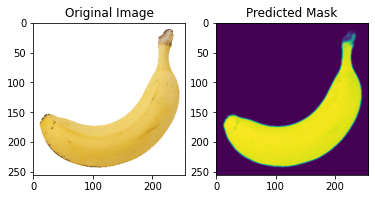

In [ ]:
#testing model on the image which is from outside of data
test_image = load_img('/content/drive/MyDrive/TestImageForClassificationAndSegmentation/Bananaimage.jpeg', target_size=(256,256))
test_image = img_to_array(test_image)
test_image = test_image / 255
mask_test = reconstructed_model.predict(test_image[np.newaxis, :])
plt.subplot(1, 2, 1) # row 1, col 2 index 1
plt.imshow(test_image)
plt.title("Original Image")

plt.subplot(1, 2, 2)
plt.imshow(mask_test[0,:,:,0])
plt.title("Predicted Mask")